In [1]:
import sys
import os
#sys.path.append('/duvalldrive/test_g/post_candidacy/cus_load_sentiment_model.ipynb')
sys.path.insert(0, os.path.abspath('/duvalldrive/test_g/post_candidacy'))
from torch.utils.data import Dataset
import re

from  cus_load_embedd import load_filtered_embeddings
from  cus_load_embedd import pad_sequences
from cus_load_embedd import load_sentiment_model
from cus_load_embedd import load_sentiment_model_multiple_attn
from cus_load_embedd import create_dataloader

# for abgradcon only

In [2]:
def label_gen(EMB_PATHLST,EMB_LAYER,max_count):
    count = 0
    all_labels = []

    for EMB_PATH in EMB_PATHLST:
        Xs = []
        for file in os.listdir(EMB_PATH):
            if os.path.isfile(os.path.join(EMB_PATH, file)):
                fn = f'{EMB_PATH}/{file}'
                embs = torch.load(fn)

                # Check label and representation conditions
                if ('hypothetical' not in str(embs['label'])
                    and 'proteobact' not in str(embs['label']) and len(embs['representations'][EMB_LAYER]) < 480):

                    Xs.append(embs['label'])
                    count += 1

                    # Check max count condition
                    if count >= max_count:
                        break

        all_labels.extend(Xs)
        count = 0 # Reset count after each directory

    return all_labels

# this function will get the embeddings for each proteins 
def read_embeddings(EMB_PATHLST, EMB_LAYER, label, max_count):
    count = 0
    all_data = []
    for EMB_PATH in EMB_PATHLST:
        Xs = []
        ys = []
        for file in os.listdir(EMB_PATH):
            if os.path.isfile(os.path.join(EMB_PATH, file)):
                fn = f'{EMB_PATH}/{file}'
                embs = torch.load(fn)

                # Check label and representation conditions
                if ('hypothetical' not in str(embs['label']) and 'proteobact' not in str(embs['label'])
                    and len(embs['representations'][EMB_LAYER]) < 480):
                    
                    
                        print (len(embs['representations'][EMB_LAYER]))
                        Xs.append(embs['representations'][EMB_LAYER])
                        ys.append(embs['label'])
                        count += 1

                        # Check max count condition
                        if count >= max_count:
                            break

        all_data.append((Xs, ys))
        count = 0 # Reset count after each directory

    return all_data
# this function  can  merge two categories list into one    
def mergelst(*args):
    newlst = []
    for lst in args:
        newlst += lst
    return newlst
# this function is for padding of data
def padding(data, batch_size):
    Xs_list = []
    ys_list = []
    for batch_start in range(0, len(data), batch_size):
        batch_data = data[batch_start:batch_start+batch_size]
        batch_Xs = []
        batch_ys = []
        for Xs, ys in batch_data:
            batch_ys.extend(ys)
            for x in Xs:
                batch_Xs.append(x)
        padded_seqs = rnn_utils.pad_sequence(batch_Xs, batch_first=True)
        tensor_list = torch.split(padded_seqs, split_size_or_sections=len(Xs), dim=0)
        batch_Xs = torch.cat(tensor_list, dim=0)
        Xs_list.append(batch_Xs)
        ys_list.append(batch_ys)
    
    Xs = torch.cat(Xs_list, dim=0)
    ys = sum(ys_list, [])
    return (Xs, ys)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader, Dataset
class Chl_Classifier_5(nn.Module):
    def __init__(self):
        super(Chl_Classifier_5, self).__init__()
        self.fc1 = nn.Linear(1280, 256)  # First hidden layer
        self.fc2 = nn.Linear(256, 128)  # Second hidden layer
        self.fc3 = nn.Linear(128, 64)   # Third hidden layer
        #self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64, 3)     # Output layer
        self.relu = nn.ReLU()
        self.attention1 = nn.Linear(256, 1)  # Attention mechanism for h1
        self.attention2 = nn.Linear(128, 1)  # Attention mechanism for h2
        self.attention3 = nn.Linear(64, 1)   # Attention mechanism for h3
        self.dropout = nn.Dropout(0.5)  # Dropout layer with 50% dropout rate
    def forward(self, x):
        batch_size = x.shape[0]
        seq_len = x.shape[1]
        x = x.view(-1, 1280)  # Reshape the input tensor
        h1 = self.relu(self.fc1(x))
        h1 = self.dropout(h1)  # Apply dropout to h1
        h2 = self.relu(self.fc2(h1))
        h2 = self.dropout(h2)  # Apply dropout to h2

        h3 = self.relu(self.fc3(h2))
        h3 = self.dropout(h3)  # Apply dropout to h3

        h1 = h1.view(batch_size, -1, 256)  # Reshape hidden layer output
        h2 = h2.view(batch_size, -1, 128)  # Reshape hidden layer output
        h3 = h3.view(batch_size, -1, 64)  # Reshape hidden layer output

        padding_mask = (x.view(batch_size, seq_len, -1).sum(dim=-1) != 0)  # Create a mask where padding tokens are False and non-padding tokens are True
        padding_mask = padding_mask.to(torch.float32)  # Convert the mask to float
        padding_mask = padding_mask.masked_fill(padding_mask == 0, float('-inf'))  # Replace False values with a large negative number
        padding_mask = padding_mask.masked_fill(padding_mask == 1, 0)  # Replace True values with 0

        e1 = self.attention1(h1).view(batch_size, -1)  # Compute attention scores for h1
        e2 = self.attention2(h2).view(batch_size, -1)  # Compute attention scores for h2
        e3 = self.attention3(h3).view(batch_size, -1)  # Compute attention scores for h3

        masked_e1 = e1 + padding_mask  # Apply the mask to the attention scores for h1
        masked_e2 = e2 + padding_mask  # Apply the mask to the attention scores for h2
        masked_e3 = e3 + padding_mask  # Apply the mask to the attention scores for h3

        alpha1 = nn.functional.softmax(masked_e1, dim=1)  # Compute the softmax function on the masked attention scores for h1
        alpha2 = nn.functional.softmax(masked_e2, dim=1)  # Compute the softmax function on the masked attention scores for h2
        alpha3 = nn.functional.softmax(masked_e3, dim=1)  # Compute the softmax function on the masked attention scores for h3

        context1 = torch.bmm(alpha1.unsqueeze(1), h1).squeeze(1)  # Apply attention to h1
        context2 = torch.bmm(alpha2.unsqueeze(1), h2).squeeze(1)  # Apply attention to h2
        context3 = torch.bmm(alpha3.unsqueeze(1), h3).squeeze(1)  # Apply attention to h3
        #print (f"context 3 shape is {context3.shape}")
        # Pass context3 through the third hidden layer
       # h4 = self.relu(self.fc3(context3))

        # Compute output
        output = nn.functional.softmax(self.fc4(context3), dim=1)

        #context = torch.cat([context1, context2, context3], dim=1)  # Concatenate the attention contexts

       # output = nn.functional.softmax(self.fc4(context), dim=1)  # Apply softmax to the output layer

        return output, alpha1, alpha2, alpha3

In [4]:
biosynt_lst =[]
ps_without_cl =[]
ps_with_cl =[]
non_ph_biosynt =[]
for dirpath, dirnames, filenames in os.walk("."):
        for dir in dirnames:
            if dir.startswith("fold") and dir.endswith("perembed"):
                print (dir)
                if not  re.search(r'^fold_ps', dir) and not dir.startswith("fold_chla-b_binding"):
                    
                    if not dir.startswith("fold_non_photo"): # to get biosynthesis proteins 
                        biosynt_lst.append (os.path.join(dirpath, dir))
                    else:
                        non_ph_biosynt.append(os.path.join(dirpath, dir)) 
                if re.search(r'^fold_ps_without', dir) : # to get non chl binding ps proteins
                    ps_without_cl.append(os.path.join(dirpath,dir))
                if re.search(r'^fold_ps_with_', dir) :   
                    ps_with_cl.append(os.path.join(dirpath,dir))# 
                    print (dir)



fold_ps_with_cl_perembed
fold_ps_with_cl_perembed
fold_ps_without_cl_perembed
fold_filtered_vinylreduct_perembed
fold_filtered_protoporph_perembed
fold_filtered_chl_synthase_perembed
fold_filtered_protoporph_ester_perembed
fold_filtered_protochlorophyllide_perembed
fold_chla-b_binding_perembed
fold_non_photo_biosynt_perembed


In [7]:
# getting labels of each categories
label_0 = label_gen(mergelst(ps_with_cl,biosynt_lst),33,50)
label_1 = label_gen(ps_without_cl,33,50)
label_2 = label_gen(non_ph_biosynt,33,50)

In [5]:
# embeddings for chl binding (positive)   data 
data_0 = read_embeddings(mergelst(ps_with_cl,biosynt_lst) ,33,0,50)
# embeddings for non _chl binding ps   data
data_1 = read_embeddings( ps_without_cl,33,1,50)

# embedding for rest of the proteins (negative) data
data_2 = read_embeddings(non_ph_biosynt,33,2,50)


352
359
351
360
360
352
358
360
352
360
360
353
360
460
352
360
353
360
352
360
356
360
45
360
360
351
465
354
465
352
460
454
360
460
324
361
453
360
360
352
462
351
351
371
352
331
358
460
360
352
186
342
228
228
233
227
230
225
230
237
228
230
227
229
230
228
228
227
227
228
230
237
230
228
234
228
236
241
237
228
231
237
237
236
228
237
228
230
228
230
228
226
230
227
228
227
228
239
237
239
228
230
307
336
317
330
340
333
326
348
315
337
338
327
308
317
330
353
333
348
344
350
359
289
326
337
338
336
339
330
330
317
338
348
317
340
326
323
343
337
340
338
328
344
330
317
330
341
340
338
336
330
358
358
380
358
358
352
358
358
358
358
368
358
358
355
364
360
358
358
358
369
361
358
352
358
356
352
358
358
358
363
363
354
358
358
358
358
349
357
358
358
352
363
358
389
363
358
354
357
358
359
316
324
288
127
319
296
288
290
320
129
319
322
296
288
53
321
320
320
322
320
320
322
61
322
320
288
54
56
302
320
296
296
288
287
320
288
319
320
319
320
322
127
313
320
320
318
288
322
51
31

In [9]:
# to get random slices for quality plot 
import numpy as np
import random
import pandas as pd

def get_random_slice(data, slice_size):
    actual_slice_size = min(len(data), slice_size)
    indices = random.sample(range(len(data)), actual_slice_size)
    data_slice = [data[i] for i in indices]
    return data_slice, indices

# Extract the values and labels from data_0, data_1, and data_2
def extract_values_labels(data):
    values = []
    labels = []

    for Xs, ys in data:
        for x in Xs:
            values.append(x)
            labels.append(ys[0])

    return values, labels

def extract_labels(data):
    labels =[]
    for Xs in data:
        for x in Xs:
            labels.append(x)
    return labels 


data_0_values, data_0_categ = extract_values_labels(data_0)
data_1_values, data_1_categ = extract_values_labels(data_1)
data_2_values, data_2_categ = extract_values_labels(data_2)

label_sin_0 = extract_labels(label_0)
label_sin_1 = extract_labels(label_1)
label_sin_2 = extract_labels(label_2)




# Get random slices of size 10 from the values and labels of data_0, data_1, and data_2
slice_size = 10
slice_idx_2 = 10

# Get the random indices first
idx_0 = random.sample(range(len(data_0_values)), slice_size )
idx_1 = random.sample(range(len(data_1_values)),slice_size )
idx_2 = random.sample(range(len(data_2_values)), slice_idx_2)

# Use the same indices for values and labels
data_0_val_slice = [data_0_values[i] for i in idx_0]
data_0_label_slice = [label_sin_0[i] for i in idx_0]
data_0_categ_slice = [0] * len(data_0_val_slice)
data_1_val_slice = [data_1_values[i] for i in idx_1]
data_1_label_slice = [label_sin_1[i] for i in idx_1]
data_1_categ_slice = [1] * len(data_1_val_slice)

data_2_val_slice = [data_2_values[i] for i in idx_2]
data_2_label_slice = [label_sin_2[i] for i in idx_2]
data_2_categ_slice = [2] * len(data_2_val_slice)


# Verify that the indices match
#assert data_0_val_slice == data_0_label_slice, "Mismatch in indices between values and labels for data_0"
#assert data_1_val_slice == data_1_label_slice, "Mismatch in indices between values and labels for data_1"
#assert data_2_val_slice == data_2_label_slice, "Mismatch in indices between values and labels for data_2"


# Combine the values and labels slices
data_0_slice = list(zip(data_0_val_slice, data_0_categ_slice))
data_1_slice = list(zip(data_1_val_slice, data_1_categ_slice))
data_2_slice = list(zip(data_2_val_slice, data_2_categ_slice))

In [10]:
# getting embedddings of both data along with their label in a single dataframe
Xs_list = []
ys_list = []
for Xs, ys in data_0_slice + data_1_slice + data_2_slice :

        Xs_list.append(Xs)
        ys_list.append(ys)
import torch.nn.functional as F

padded_Xs_list =[]
max_length = 450
for i in Xs_list:
    
    # Calculate the length of the sequence
    seq_length = i.size(0)
    # Pad the sequence
    if seq_length < max_length:
        padded_seq = F.pad(i, (0,0,0, max_length-seq_length), value=0)
        
    else:
        padded_seq = i[:max_length]
    
    padded_Xs_list.append(padded_seq)        

In [22]:
from sklearn.model_selection import KFold
# Import the required functions
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
# Define a dataset class for the labeled sentences
class Chl_Dataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
       # print ("This is self.labels")
        return self.sentences[idx], self.labels[idx]
# Stack the tensors along a new dimension to create a single 3D tensor
input_data = torch.stack(padded_Xs_list, dim=0)

# Assume that labels is a tensor with shape (num_examples,)
labels = ys_list
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(input_data, labels, test_size=0.2, random_state=42)
# Split the data into training and testing sets
#dataset = SentimentDataset(input_data, labels)
dataset = Chl_Dataset(X_train, y_train)

In [12]:
input_data.shape

torch.Size([30, 450, 1280])

In [14]:
padded_Xs_list

[tensor([[ 0.0008, -0.0647, -0.0316,  ...,  0.1418, -0.1047,  0.0803],
         [ 0.0788, -0.1736, -0.1012,  ..., -0.0443,  0.2150,  0.0981],
         [-0.1171, -0.0380, -0.1260,  ...,  0.0297,  0.0663,  0.0733],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 tensor([[ 0.0486, -0.0893, -0.0452,  ...,  0.0782, -0.0099,  0.2494],
         [-0.0093,  0.2890, -0.2006,  ..., -0.2508,  0.2172, -0.0164],
         [ 0.1162,  0.1287, -0.0734,  ..., -0.0018,  0.0151, -0.0221],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 tensor([[ 0.0677, -0.1047, -0.0814,  ...,  0.1225, -0.1935,  0.1810],
         [ 0.0701,  0.2925, -0.0786,  ..., -0

In [17]:
model_dict_path = "model_fold1.pt"
model = Chl_Classifier_5()
weights_dict = torch.load(model_dict_path)
model.load_state_dict(weights_dict)
model.eval()
#output, alpha1, alpha2, alpha3 = model(dataset)
dataload = create_dataloader(dataset, 20)
#visualize_attention(model, dataload,3)


In [ ]:
batch_sentences

this is 0 batch
tensor([2, 2, 1, 0, 0, 1, 0, 1, 1, 2, 0, 0, 2, 0, 2, 2, 1, 2, 2, 0])
actual:tensor([2, 2, 1, 0, 0, 1, 0, 1, 1, 2, 0, 0, 2, 0, 2, 2, 1, 2, 2, 0])


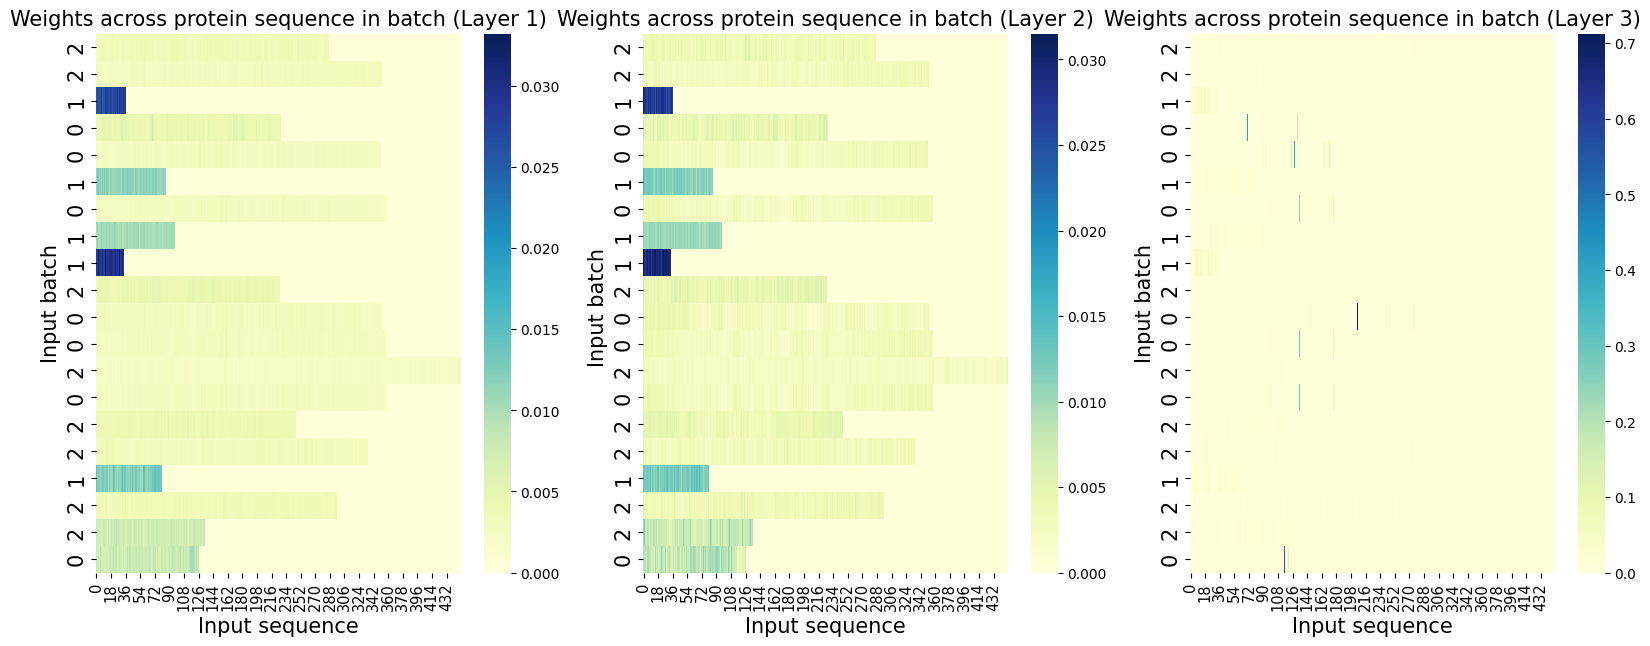

In [19]:
fontsize =15
for i, (batch_sentences, batch_labels) in enumerate(dataload):
    # Check if we've processed three batches
    if i >= 1:
        break
    print (f'this is {i} batch') 
    with torch.no_grad():
        output, alpha1, alpha2, alpha3 = model(batch_sentences[0])
        x = batch_sentences[0]
        _, predicted = torch.max(output, 1)
        print (predicted)
        print(f"actual:{batch_sentences[1]}")


        batch_labels = predicted

        # Reshape the attention weights to match the input sequence dimensions
        batch_size, seq_len, _ = x.shape
        alpha1 = alpha1.reshape(batch_size, seq_len)
        alpha2 = alpha2.reshape(batch_size, seq_len)
        alpha3 = alpha3.reshape(batch_size, seq_len)

        # Create subplots for each set of attention weights
        fig, axs = plt.subplots(1, 3, figsize=(20, 7))

        # Plot attention weights for the first head
        sns.heatmap(alpha1.detach().numpy(), cmap="YlGnBu", ax=axs[0])
        #axs[0].set_xticks(fontsize =15)


         # Set y-axis tick labels
            
        axs[0].set_yticks(np.arange(len(batch_labels))+0.5)
        axs[0].set_yticklabels(batch_labels.tolist(),fontsize=fontsize)

        axs[0].set_xlabel("Input sequence",fontsize=fontsize)
        axs[0].set_ylabel("Input batch",fontsize=fontsize)
        axs[0].set_title("Weights across protein sequence in batch (Layer 1)",fontsize=fontsize)
        axs[0].tick_params(axis='x', labelsize=10.5)  # Set x-axis tick label font size
 
        # Plot attention weights for the second head
        sns.heatmap(alpha2.detach().numpy(), cmap="YlGnBu", ax=axs[1])
        axs[1].set_yticks(np.arange(len(batch_labels))+0.5)
        axs[1].set_yticklabels(batch_labels.tolist(),fontsize =fontsize)

        axs[1].set_xlabel("Input sequence",fontsize =fontsize)
        axs[1].set_ylabel("Input batch ",fontsize=fontsize)
        axs[1].set_title("Weights across protein sequence in batch (Layer 2)",fontsize=fontsize)
        axs[1].tick_params(axis='x', labelsize=10.5)  # Set x-axis tick label font size


        # Plot attention weights for the third head
        sns.heatmap(alpha3.detach().numpy(), cmap="YlGnBu", ax=axs[2])
        axs[2].set_yticks(np.arange(len(batch_labels))+0.5)
        axs[2].set_yticklabels(batch_labels.tolist(),fontsize=fontsize)

        axs[2].set_xlabel("Input sequence",fontsize=fontsize)
        axs[2].set_ylabel("Input batch",fontsize=fontsize)
        axs[2].set_title("Weights across protein sequence in batch (Layer 3)",fontsize=fontsize)
        axs[2].tick_params(axis='x', labelsize=10.5)  # Set x-axis tick label font size

        #plt.savefig("attention_weights_abgradcon.pdf", format='pdf')


        plt.show()